In [1]:
# enables the use of R code in a cell after writing "%%R making it an cell for R code 
%load_ext rpy2.ipython   

In [2]:
%%R 
# path_rbeni = "/home/martina/SynologyDrive/MasterThesis/rsvi/data/rbeni-master/"
# path_ingestr = "/home/martina/SynologyDrive/MasterThesis/rsvi/data/ingestr-master/"
path_rbeni = "/home/zhud/wsl/MasterThesis/rsvi/data/rbeni-master/"
path_ingestr = "/home/zhud/wsl/MasterThesis/rsvi/data/ingestr-master/"

In [3]:
%%capture
%%R 
# %R [-i INPUT] [-o OUTPUT] [-n] [-w WIDTH] [-h HEIGHT] [-p POINTSIZE]
#    [-b BG] [–noisolation] [-u {px,in,cm,mm}] [-r RES] [–type {cairo,cairo-png,Xlib,quartz}] [-c CONVERTER] [-d DISPLAY] [code [code …]]
# https://rpy2.github.io/doc/latest/html/interactive.html
# nothing is returned to python by default in cell mode %%R
# %Rpull
#    %Rpull [outputs [outputs …]]
#%Rget
#    %Rget output
# %%capture is here because rbeni plots something

source("remove_outliers.R")      # code from predecessors
source("gather_data.R")
source("gather_data_bands.R")
source("align_events.R")
# source("plot_rsvi.R")          # not used anymore? should they be deleted?
# source("plot_compare.R")
# source("rsvi_sites.R")
# source("add_scaled_rsvi.R")
# source("add_normalised_rsvi.R")
source("MOD09_MODOC_filter.R")
source("wrap_ml.R")

library(dplyr)                  # not available packages can be installed over R / R studio
library(lubridate)              # https://rpy2.github.io/doc/v2.9.x/html/robjects_rpackages.html
library(readr)
library(ggplot2)
library(tidyr)                  # for the not so simple vignette
library(caret)
library(tidyverse)              
library(yardstick)     
library(recipes)
library(caret)
library(binaryLogic)
library(patchwork)
library(LSD)
library(ggthemes)
library(RColorBrewer)
library(devtools)
devtools::load_all(path_rbeni)
library(rbeni)                                       
devtools::load_all(path_ingestr)
library(ingestr)
library(stringr)

# Shortcut N2:
# load("./data/ddf_v5.Rdata")
# load("./data/metainfo_Tier1_sites_kgclimate_fluxnet2015.Rdata")

# Preprocessed data (subset for homogeneous sites, filtered by quality, merged with flue data and towres data)
load("./data/obs_eval_NT.Rdata")    # for site and date contains information about: fapar <dbl>, ccov_cru_int <dbl>, temp_fluxnet2015 <dbl>, prec_fluxnet2015 <dbl>,
                                    #                                              vpd_fluxnet2015 <dbl>, ppfd_fluxnet2015 <dbl>, gpp_obs <dbl>,
                                    #                                              transp_obs <dbl>, soilm_obs_mean <dbl>, temp <dbl>, GPP_NT_VUT_REF <dbl>,
                                    #                                              GPP_DT_VUT_REF <dbl>, year <dbl>

Failed to create bus connection: No such file or directory


# Analysis

### Site selection and complement data with flue data
Subset homogenous sites. Selection of sites is based on whether sites could be allocated to clusters in Stocker et al. (2018) and based on the selection by Manuela Balzarolo (see `site_selection_rsvi.Rmd`).
Get fLUE Stocker et al., 2018 publicly available data here: https://zenodo.org/record/1158524#.W_bNMZNKjOQ

In [4]:
%%R
# read in satellite Data
# todo: adapt satellite data
ddf <- read_csv("./data/FLUXNET_MODOCGA_MOD09GA_MYD11A1.csv") 
# read in homogeneous sites and use them as a filter for the satellite data
df_homo <- read_csv("./data/sites2.csv")
ddf <- ddf %>% 
    dplyr::filter( sites %in% df_homo$sitename) %>%
    rename(site = sites) %>%
    mutate(date = ymd(paste(as.character(YY), as.character(MM), as.character(DD), sep="-")))
# include information about flue and if it is indicating a drought
ddf <- read_csv("data/flue_stocker18nphyt.csv") %>% 
  dplyr::select(site, date, flue, is_flue_drought) %>%
  right_join(ddf, by=c("site", "date"))
summary(ddf)

Rows: 241826 Columns: 26
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): sites
dbl (25): YY, MM, DD, lst_aqua, b01, b02, b03, b04, b05, b06, b07, b08, b09,...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 31 Columns: 15
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): sitename, cluster, classid, koeppen_code, koeppen_code_extr
dbl (8): lon, lat, elv, year_start, year_end, years_data, whc, kgnumber
lgl (2): c4, homogenous_mbalzarolo

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 233369 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): site, cluster
dbl  (3): year, doy, flue
lgl  (1): 

In [5]:
%%R
# analyse lst from aqua 
# at the moment the length of ddf is 12748 
# one important factor of summary(ddf) is the number of NA's
# ddf_lst_aqua has nearly no datapoints left if b16 and b15 are to be included in the analysis and the NA's are to be removed.
# lst also contains quite a bit of NA's is however necessary for the analysis of its use as one of the predicors of flue.
ddf_paula <- ddf %>% 
    select(date, site, flue, is_flue_drought, ndvi, evi, NIRv, cci, pri)
ddf_lst_aqua <- ddf %>% 
    select(date, site, flue, is_flue_drought, lst_aqua, b01, b02, b03, b04, b05, b06, b07, b08, b09, b10, b11, b12, b13, b14, b15, b16) 
ddf_lst_aqua_b01_to_b14 <- ddf %>% 
    select(date, site, flue, is_flue_drought, lst_aqua, b01, b02, b03, b04, b05, b06, b07, b08, b09, b10, b11, b12, b13, b14) 
ddf_lst_aqua_indices <- ddf %>% 
    select(date, site, flue, is_flue_drought, lst_aqua, ndvi, evi, NIRv, cci, pri)
ddf_lst_aqua_bands_for_indices <- ddf %>% 
    select(date, site, flue, is_flue_drought, lst_aqua, b02, b01, b03, b11, b12) # bands used to calculate indices
    
# todo: implement results for terra
# todo: test how many nan are in each column of ddf_lst_aqua (and the same for terra)


#### Tidy data

Complement info using the meta info of FLUXNET sites provided through rsofun.
Includes temperature, APAR, and select only 5 vegetation classes. Clean database, no NA

In [6]:
%%R
add_meta_info_and_clean <- function(ddf){

    # Vegetation classes
    cv <- c("ENF","DBF","GRA","EBF","SAV")

    ddf_nn <- ddf %>%
        left_join(siteinfo_fluxnet2015 %>% dplyr::select(site=sitename, classid), by = "site") %>%
        left_join(dplyr::rename(obs_eval_NT$ddf, site=sitename), by=c("site", "date")) %>%
        mutate (APAR = ppfd_fluxnet2015 * fapar) %>%
        dplyr::filter(!is.na(flue)) %>%
        # dplyr::select(date, site, is_flue_drought, flue, all_of(dovars), APAR, temp, classid) %>%
        mutate(classid=factor(classid), is_flue_drought = factor(is_flue_drought)) %>%
        drop_na()

    # Subset ONLY 5 classes (cv)
    ddf_nn$classid[ddf_nn$classid=="WSA"] <- "SAV"
    ddf_sub <- ddf_nn %>%
        dplyr::filter(classid %in% cv) %>% 
        droplevels()
    # deparse(substitute(variableName)) becomes part of the Rdata name
    filename <- str_glue('./data/{deparse(substitute(ddf))}_sub.Rdata')
    save(ddf_sub, file = filename)
}

In [7]:
%%R
# add_meta_info_and_clean(ddf_paula)
# add_meta_info_and_clean(ddf_lst_aqua)
add_meta_info_and_clean(ddf_lst_aqua_b01_to_b14)
# add_meta_info_and_clean(ddf_lst_aqua_indices)
# add_meta_info_and_clean(ddf_lst_aqua_bands_for_indices)

Predictors and data ready to train (ddf_sub)


In [12]:
%%R
# load("./data/ddf_paula_sub.Rdata")                      # 2000-10-11 to 2014-12-30, 2923 entries
                                                          # Startdatum Aqua: 4. Mai 2002
                                                          #                  LST has many missing values
# load("./data/ddf_lst_aqua_sub.Rdata")                   
load("./data/ddf_lst_aqua_b01_to_b14_sub.Rdata")          # 105,990 entries, 41766 NA flue
# load("./data/ddf_lst_aqua_indices_sub.Rdata")           
# load("./data/ddf_lst_aqua_bands_for_indices_sub.Rdata") 

In [13]:
%%R
paula                      <- c("ndvi", "evi", "cci", "pri", "NIRv", "APAR",  "temp", "classid")
lst_aqua_indices           <- c("ndvi", "evi", "cci", "pri", "NIRv", "APAR", "lst_aqua",  "classid")
lst_aqua_bands_for_indices <- c("b01", "b02", "b03", "b11", "b12", "classid")
lst_aqua                   <- c("b01", "b02", "b03", "b04", "b05", "b06", "b07", 
                                "b08", "b09", "b10", "b11", "b12", "b13", "b14", "b15", "b16", 
                                "lst_aqua", "classid")
lst_aqua_b01_to_b14        <- c("b01", "b02", "b03", "b04", "b05", "b06", "b07", 
                                "b08", "b09", "b10", "b11", "b12", "b13", "b14", 
                                "lst_aqua", "classid")
pred_var <- lst_aqua_b01_to_b14
sites <- ddf_sub$site %>% unique()

### Drought classification

Predictions of drought or non-drought days.

#### Single split (global model)

Must be split by site.

In [14]:
%%R
set.seed(1982)
cat("There are ",length(sites),"sites and thus nsites_train is",length(sites)-2)
nsites_train <- floor(0.8*length(sites))
sites_train <- sample(sites, nsites_train)
df_train <- ddf_sub %>% 
  dplyr::filter(site %in% sites_train)
df_test <- ddf_sub %>% 
  dplyr::filter(!(site %in% sites_train))

There are  22 sites and thus nsites_train is 20

In [15]:
%%R
sites

 [1] "AU-Ade" "AU-ASM" "AU-DaP" "AU-DaS" "AU-Dry" "AU-Stp" "AU-Wom" "DE-Obe"
 [9] "DE-Tha" "FI-Hyy" "FR-LBr" "IT-Cpz" "IT-Ro1" "IT-SRo" "NL-Loo" "RU-Fyo"
[17] "SD-Dem" "US-MMS" "US-SRG" "US-SRM" "US-UMB" "US-UMd"


In [16]:
%%R
df_homo$sitename
# why are there so little sites left...

 [1] "AR-Vir" "AU-Ade" "AU-ASM" "AU-DaP" "AU-DaS" "AU-Dry" "AU-How" "AU-Stp"
 [9] "AU-Wom" "CH-Lae" "DE-Kli" "DE-Obe" "DE-Spw" "DE-Tha" "FI-Hyy" "FR-Fon"
[17] "FR-LBr" "FR-Pue" "IT-Cpz" "IT-Ro1" "IT-SRo" "JP-SMF" "NL-Loo" "RU-Fyo"
[25] "SD-Dem" "US-Ha1" "US-MMS" "US-SRG" "US-SRM" "US-UMB" "US-UMd"


Train model on a single training set and evaluate on the single testing set from the initial split


In [17]:
import os
if not os.path.exists("results"):
    os.makedirs("results")

In [18]:
%%R
# Train model on a single training set and evaluate on the single testing set from the initial split
filepath  <- str_glue('./results/modl_is_flue_drought_nnet_GLOBAL_{deparse(substitute(pred))}.Rdata')
filepath

./results/modl_is_flue_drought_nnet_GLOBAL_pred.Rdata
FALSE


<span style="color:red">**Analysis Task:**</span> 
- write a more structured To do list.
- Use different ML algorithms of wrap_ml, start simpe then use logicaly potential alternatives (gaussian processing - maybe the point sources are too far appart?, ...? ) compare them ? roc curve?
- the hydraulic computation presentation was combining point sources and satellite data through machine learning.Can the point source data be reused for the modelling? Even though it aso trained the satellite data. Still it more precise.
- roc improvement of including variables?
- Consider the time as well
- Write something to save the plots

In [19]:
%%R
# Train model on a single training set and evaluate on the single testing set from the initial split
filn <- "./results/modl_is_flue_drought_nnet_GLOBAL_lst_aqua_b01_to_b14_1.Rdata"
if (!file.exists(filn)){
  modl <- wrap_ml( df = df_train,
                   nam_target = "is_flue_drought",
                   nam_group = "site",
                   method =  "nnet",
                   train_method = "myLGOCV",
                   predictors = pred_var,
                   tune = FALSE,
                   inner = FALSE,
                   classification = TRUE
                  )
  ## save model object
  save(modl, file = filn)

} else {
  load(filn)
}

df_test$pred <- predict(modl, newdata = df_test)

confusionMatrix(data = df_test$pred, reference = df_test$is_flue_drought)
postResample(pred = df_test$pred, obs = df_test$is_flue_drought)

# is an accuracy of about 70% good? what would be useful. 
# Should there be a distintion between false positive and false negative?

 Accuracy     Kappa 
0.7487702 0.5068954 


In [16]:
%%R
df_test$pred <- predict(modl, newdata = df_test)

confusionMatrix(data = df_test$pred, reference = df_test$is_flue_drought)
postResample(pred = df_test$pred, obs = df_test$is_flue_drought)

# is an accuracy of about 70% good? what would be useful. 
# Should there be a distintion between false positive and false negative?

 Accuracy     Kappa 
0.7487702 0.5068954 


#### Leave-group-out split 

This is to assess the variance of evaluation metrics derived from test sets.

In [20]:
%%R
filn <- "./results/modl_is_flue_drought_nnet_INNER_lst_aqua_b01_to_b14_full.Rdata"
if (!file.exists(filn)){
  modl <- wrap_ml( df = ddf_sub,
                   nam_target = "is_flue_drought",
                   nam_group = "site",
                   method =  "nnet",
                   train_method = "myLGOCV",
                   predictors = pred_var,
                   tune = FALSE,
                   inner = TRUE,
                   classification = TRUE
                  )
  
  ## save model object (WARNING: IS A BIT BIG)
  save(modl, file = filn)
} else {
  load(filn)
}

[1] "training model with leave-site-out: AU-Ade ..."
[1] "training model with leave-site-out: AU-ASM ..."
[1] "training model with leave-site-out: AU-DaP ..."
[1] "training model with leave-site-out: AU-DaS ..."
[1] "training model with leave-site-out: AU-Dry ..."
[1] "training model with leave-site-out: AU-Stp ..."
[1] "training model with leave-site-out: AU-Wom ..."
[1] "training model with leave-site-out: DE-Obe ..."
[1] "training model with leave-site-out: DE-Tha ..."
[1] "training model with leave-site-out: FI-Hyy ..."
[1] "training model with leave-site-out: FR-LBr ..."
[1] "training model with leave-site-out: IT-Cpz ..."
[1] "training model with leave-site-out: IT-Ro1 ..."
[1] "training model with leave-site-out: IT-SRo ..."
[1] "training model with leave-site-out: NL-Loo ..."
[1] "training model with leave-site-out: RU-Fyo ..."
[1] "training model with leave-site-out: SD-Dem ..."
[1] "training model with leave-site-out: US-MMS ..."
[1] "training model with leave-site-out: US-SR

Get evaluation results across left-out sites from inner loop.

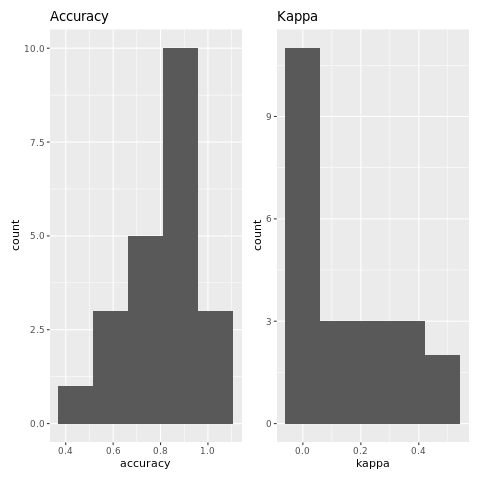

In [21]:
%%R
df_inner <- purrr::map(modl, "results") %>% 
  purrr::map_dbl("accuracy") %>% 
  stack() %>% 
  dplyr::select(site = ind, accuracy = values) %>% 
  left_join(
    purrr::map(modl, "results") %>% 
      purrr::map_dbl("kappa") %>% 
      stack() %>% 
      dplyr::select(site = ind, kappa = values),
    by = "site"
  )

df_inner %>% knitr::kable()

df_inner %>% 
  summarise(kappa_mean = mean(kappa), accuracy_mean = mean(accuracy),
            kappa_median = median(kappa), accuracy_median = median(accuracy),
            kappa_sd = sd(kappa), accuracy_sd = sd(accuracy)) %>% 
  knitr::kable()
# why so little bins? was 5
gg1 <- df_inner %>% 
  ggplot(aes(x = kappa, y = ..count..)) +
  geom_histogram(bins = 5) +                       
  labs(title = "Kappa")

gg2 <- df_inner %>% 
  ggplot(aes(x = accuracy, y = ..count..)) +
  geom_histogram(bins = 5) +
  labs(title = "Accuracy")

library(patchwork)
gg2 + gg1

Combine predictions on test sets from the inner loop (on the single held-out site). This is the most relevant metric here!

In [22]:
%%R
df_test_inner <- purrr::map_dfr(modl, "df_test")
confusionMatrix( data = df_test_inner$pred,
                 reference = df_test_inner$is_flue_drought, 
                 positive = "TRUE"
                 )

Confusion Matrix and Statistics

          Reference
Prediction FALSE TRUE
     FALSE  5790 1707
     TRUE   1024 4783
                                          
               Accuracy : 0.7947          
                 95% CI : (0.7878, 0.8016)
    No Information Rate : 0.5122          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.5882          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.7370          
            Specificity : 0.8497          
         Pos Pred Value : 0.8237          
         Neg Pred Value : 0.7723          
             Prevalence : 0.4878          
         Detection Rate : 0.3595          
   Detection Prevalence : 0.4365          
      Balanced Accuracy : 0.7934          
                                          
       'Positive' Class : TRUE            
                     

### Drought magnitude

Predictions of drought magnitude.

Single split (global model)

Must be split by site.

In [23]:
%%R
set.seed(1982)
nsites_train <- floor(0.8*length(sites)) #18
sites_train <- sample(sites, nsites_train)
df_train <- ddf_sub %>% 
  dplyr::filter(site %in% sites_train)
df_test <- ddf_sub %>% 
  dplyr::filter(!(site %in% sites_train))

Train model on a single training set and evaluate on the single testing set from the initial split


In [24]:
%%R
filn <- "./results/modl_flue_nnet_GLOBAL_lst_aqua_b01_to_b14_full.Rdata"
if (!file.exists(filn)){
  modl <- wrap_ml( df = df_train,
                   nam_target = "flue",
                   nam_group = "site",
                   method =  "nnet",
                   train_method = "myLGOCV",
                   predictors = pred_var,
                   tune = TRUE,
                   inner = FALSE,
                   classification = FALSE
                  )
  ## save model object
  save(modl, file = filn)
} else {
  load(filn)
}

[1] "training full model ..."


## Leave-group-out split 

This is to assess the variance of evaluation metrics derived from test sets.

In [25]:
%%R
filn <- "./results/modl_flue_nnet_INNER_lst_aqua_b01_to_b14_full.Rdata"
if (!file.exists(filn)){
  modl <- wrap_ml( df = ddf_sub,
                   nam_target = "flue",
                   nam_group = "site",
                   method =  "nnet",
                   train_method = "myLGOCV",
                   predictors = pred_var,
                   tune = FALSE,
                   inner = TRUE,
                   classification = FALSE
                  )
  
  ## save model object (WARNING: IS A BIT BIG)
  save(modl, file = filn)
} else {
  load(filn)
}

[1] "training model with leave-site-out: AU-Ade ..."
[1] "training model with leave-site-out: AU-ASM ..."
[1] "training model with leave-site-out: AU-DaP ..."
[1] "training model with leave-site-out: AU-DaS ..."
[1] "training model with leave-site-out: AU-Dry ..."
[1] "training model with leave-site-out: AU-Stp ..."
[1] "training model with leave-site-out: AU-Wom ..."
[1] "training model with leave-site-out: DE-Obe ..."
[1] "training model with leave-site-out: DE-Tha ..."
[1] "training model with leave-site-out: FI-Hyy ..."
[1] "training model with leave-site-out: FR-LBr ..."
[1] "training model with leave-site-out: IT-Cpz ..."
[1] "training model with leave-site-out: IT-Ro1 ..."
[1] "training model with leave-site-out: IT-SRo ..."
[1] "training model with leave-site-out: NL-Loo ..."
[1] "training model with leave-site-out: RU-Fyo ..."
[1] "training model with leave-site-out: SD-Dem ..."
[1] "training model with leave-site-out: US-MMS ..."
[1] "training model with leave-site-out: US-SR

Get evaluation results across left-out sites from inner loop.


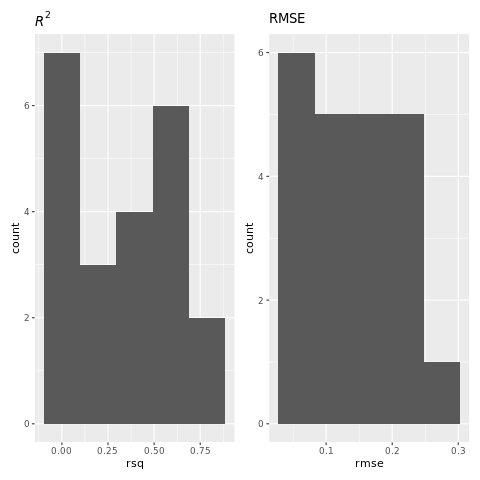

In [26]:
%%R
df_inner <- purrr::map_dfr(modl, "results") %>% 
  pivot_wider(names_from = .metric, values_from = .estimate) %>% 
  dplyr::select(-.estimator)

df_inner %>% knitr::kable()

df_inner %>% 
  summarise(rmse_mean = mean(rmse), rsq_mean = mean(rsq),
            rmse_median = median(rmse), rsq_median = median(rsq),
            rmse_sd = sd(rmse), rsq_sd = sd(rsq)) %>% 
  knitr::kable()

gg1 <- df_inner %>% 
  ggplot(aes(x = rmse, y = ..count..)) +
  geom_histogram(bins = 5) +
  labs(title = "RMSE")

gg2 <- df_inner %>% 
  ggplot(aes(x = rsq, y = ..count..)) +
  geom_histogram(bins = 5) +
  labs(title = expression(italic(R)^2))

gg2 + gg1

Combine predictions on test sets from the inner loop (on the single held-out site). This is the most relevant metric here!


$df_metrics
# A tibble: 12 × 3
   .metric  .estimator   .estimate
   <chr>    <chr>            <dbl>
 1 rmse     standard       0.159  
 2 rsq      standard       0.636  
 3 mae      standard       0.110  
 4 n        standard   13304      
 5 slope    standard       0.919  
 6 mean_obs standard       0.815  
 7 prmse    standard       0.195  
 8 pmae     standard       0.135  
 9 bias     standard       0.00628
10 pbias    standard       0.0780 
11 cor      standard       0.798  
12 cor_test standard       0      

$gg


R[write to console]: `geom_smooth()` using formula 'y ~ x'




$linmod

Call:
lm(formula = obs ~ mod, data = df)

Coefficients:
(Intercept)          mod  
     0.0604       0.9188  


$results
# A tibble: 1 × 6
    rsq  rmse   mae    bias slope     n
  <dbl> <dbl> <dbl>   <dbl> <dbl> <dbl>
1 0.636 0.159 0.110 0.00628 0.919 13304



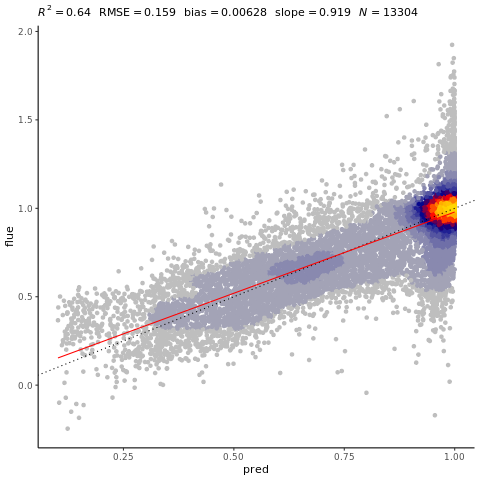

In [27]:
%%R
df_test_inner <- purrr::map_dfr(modl, "df_test")

df_test_inner %>% 
  rbeni::analyse_modobs2("pred", "flue", type = "heat")

In [28]:
%%R
df_test_inner

# A tibble: 13,304 × 36
   date       site   flue is_flue_drought lst_aqua   b01   b02   b03   b04   b05
   <date>     <chr> <dbl> <fct>              <dbl> <dbl> <dbl> <dbl> <dbl> <dbl>
 1 2007-11-10 AU-A… 0.840 TRUE                313.  592. 1814.  271.  540. 2447.
 2 2007-12-01 AU-A… 0.897 TRUE                310. 1461. 2959. 1309. 1571. 3234.
 3 2008-03-08 AU-A… 0.998 FALSE               307. 6216. 6538. 6092. 6251. 5543.
 4 2008-04-09 AU-A… 0.904 TRUE                312.  547. 2283.  252.  561. 2813.
 5 2008-04-10 AU-A… 0.879 TRUE                307.  775. 3050.  352.  775. 3873.
 6 2008-04-11 AU-A… 0.850 TRUE                310.  589. 2142.  279.  561. 2951.
 7 2008-04-12 AU-A… 0.833 TRUE                306.  742. 3431.  352.  812. 3883.
 8 2008-04-15 AU-A… 0.796 TRUE                305.  820. 2672.  386.  756. 3541.
 9 2008-04-16 AU-A… 0.780 TRUE                307.  555  2375   256   553  3076 
10 2008-04-18 AU-A… 0.763 TRUE                312.  563. 2020.  275.  532. 2719.
# … 

# NDI

In [29]:
%%R -o ddf_sub
summary(df_test_inner) # flue: Median : 0.97142, 3rd Qu.: 1.00693, Max.   : 1.84895 
summary(ddf_sub)

      date                site                flue         is_flue_drought
 Min.   :2002-07-04   Length:13304       Min.   :-0.2460   FALSE:6814     
 1st Qu.:2006-10-16   Class :character   1st Qu.: 0.6237   TRUE :6490     
 Median :2009-07-14   Mode  :character   Median : 0.8967                  
 Mean   :2009-05-20                      Mean   : 0.8146                  
 3rd Qu.:2012-03-06                      3rd Qu.: 1.0011                  
 Max.   :2014-12-30                      Max.   : 1.9244                  
    lst_aqua          b01               b02               b03         
 Min.   :272.7   Min.   :   11.5   Min.   :  420.5   Min.   :  -27.5  
 1st Qu.:292.9   1st Qu.:  367.0   1st Qu.: 2126.5   1st Qu.:  219.8  
 Median :300.9   Median :  849.9   Median : 2569.8   Median :  414.0  
 Mean   :302.4   Mean   : 1156.2   Mean   : 2792.1   Mean   :  747.6  
 3rd Qu.:311.6   3rd Qu.: 1464.8   3rd Qu.: 3196.3   3rd Qu.:  716.3  
 Max.   :336.4   Max.   :13280.2   Max.   :14036.

In [30]:
# rough estimate of wavelength of bands in [nm] 
# b01: 650 b02: 860 b03: 470 b04: 550 b05: 1240 b06: 1640 b07: 2125
# b08: 410 b09: 445 b10: 488 b11: 530 b12: 550 b13: 667 b14: 678
import seaborn as sns
import pandas as pd

In [31]:
df_bands = ddf_sub[[
    # sorted after their respective bandwidth
       'flue',
       'b01', 'b02', 'b03', 'b04', 'b05', 'b06', 'b07',
       'b08', 'b09', 'b10', 'b11', 'b12', 'b13', 'b14'
]]

In [32]:
df_bands.to_pickle("./df_bands.pkl")

In [33]:
df = pd.read_pickle("./df_bands.pkl")


In [34]:
df_wavelength = df[[
    # sorted after their respective bandwidth
       'b08', 'b09', 'b03', 'b10', 'b11', 'b12', 'b04',
       'b01', 'b13', 'b14', 'b02', 'b05', 'b06', 'b07'
]]

In [35]:
# in nm
bands_wavelength = [ '413', '445', '469', '488', '531','551',  '555',  
                     '645', '667', '678', '859','l 1240', 'l 1640', 'l 2130'  ]
df_wavelength = df_wavelength.set_axis([ '413', '445', '469', '488', '531','551', '555',  
                                         '645', '667', '678', '859','l 1240', 'l 1640', 'l 2130'  ], axis=1, inplace=False)
bands_range = [ '405-420', '438-448', '459-479', '483-493', '526-536', '546-556', '545-565',
       '620-670', '662-672', '673-683', '841-876', 'l 1230-1250', 'l 1628-1652', 'l 2105-2155'  ]
df_range = df_wavelength.set_axis( [ '405-420', '438-448', '459-479', '483-493', '526-536', '546-556', '545-565',
       '620-670', '662-672', '673-683', '841-876', 'l 1230-1250', 'l 1628-1652', 'l 2105-2155'  ], axis=1, inplace=False)

In [36]:
df_sorted = df[[  'b01', 'b02', 'b03', 'b04', 'b05', 'b06', 'b07',
               'b08', 'b09', 'b10', 'b11', 'b12', 'b13', 'b14'  ]]

In [37]:
bands_sorted = [ 'b01', 'b02','b03', 'b04', 'b05', 'b06', 'b07',
                 'b08', 'b09', 'b10', 'b11', 'b12', 'b13', 'b14' ]

In [38]:
# try to calculate a list with band1 band2 and
# band-lable
data = []
for band_i in bands_sorted:     # band1 
    for band_j in bands_sorted: # band2
        band1 = f'{band_i}'
        band2 = f'{band_j}'
        ndi_uncorrelated = (df_sorted[band_i] - df_sorted[band_j]) / (df_sorted[band_i] + df_sorted[band_j]) 
        ndi = df['flue'].corr(ndi_uncorrelated)
        data.append([band1, band2, ndi])
df_ndi_sorted = pd.DataFrame(data, columns=['band1', 'band2', 'ndi'])
# bandwidth
data = []
for band_i in bands_range:     # band1 
    for band_j in bands_range: # band2
        band1 = f'{band_i}'
        band2 = f'{band_j}'
        ndi_uncorrelated = (df_range[band_i] - df_range[band_j]) / (df_range[band_i] + df_range[band_j]) 
        ndi = df['flue'].corr(ndi_uncorrelated)
        data.append([band1, band2, ndi])
df_ndi_range = pd.DataFrame(data, columns=['band1', 'band2', 'ndi'])
# wavelength
data = []
for band_i in bands_wavelength:     # band1 
    for band_j in bands_wavelength: # band2
        band1 = f'{band_i}'
        band2 = f'{band_j}'
        ndi_uncorrelated = (df_wavelength[band_i] - df_wavelength[band_j]) / (df_wavelength[band_i] + df_wavelength[band_j]) 
        ndi = df['flue'].corr(ndi_uncorrelated)
        data.append([band1, band2, ndi])
df_ndi_wavelength = pd.DataFrame(data, columns=['band1', 'band2', 'ndi'])


In [39]:
def ndi_combinations(df, bands, criteria):
    '''
     df               dataframe        col_x - col_y
     bands            list of names of the columns in the dataframe
     criteria         a column with the same length as elements in the dataframe
     returns a list   with combinations of columns of the dataframe and the result of correlating (col_x - col_y)/(col_x - col_y) with the criteria
    '''
    data = []
    for band_i in bands:     # band1 
        for band_j in bands: # band2
            band1 = f'{band_i}'
            band2 = f'{band_j}'
            ndi_uncorrelated = (df[band_i] - df[band_j]) / (df[band_i] + df[band_j]) 
            ndi = criteria.corr(ndi_uncorrelated)
            data.append([band1, band2, ndi])
    df_ndi = pd.DataFrame(data, columns=['band1', 'band2', 'ndi'])
    ndi = df_ndi.pivot("band1", "band2", "ndi") # sorts the entries --> change to wavelength [nm]
    return ndi

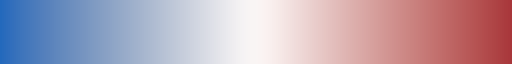

In [40]:
sns.color_palette("vlag", as_cmap=True)

<AxesSubplot:xlabel='band2', ylabel='band1'>

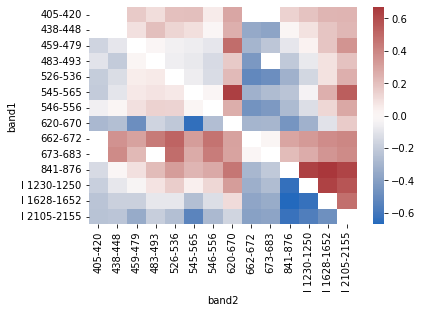

In [41]:
sns.heatmap(ndi_combinations(df_range, bands_range, df['flue']), cmap="vlag")

<AxesSubplot:xlabel='band2', ylabel='band1'>

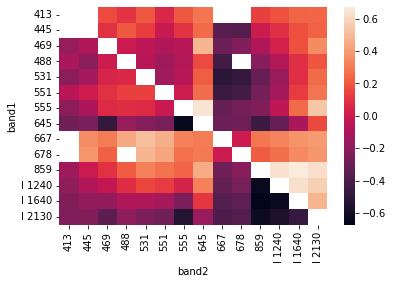

In [42]:
sns.heatmap(ndi_combinations(df_wavelength, bands_wavelength, df['flue']))
# changes only position of 551 to 555 in compare to df_range

<AxesSubplot:xlabel='band2', ylabel='band1'>

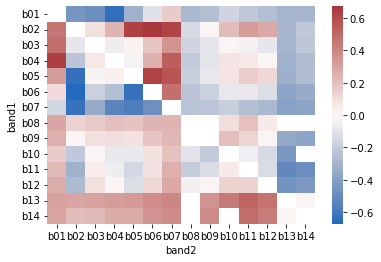

In [43]:
sns.heatmap(ndi_combinations(df_sorted, bands_sorted, df['flue']), cmap="vlag")

# Trying things out:

In [25]:
%%R
# read in criteria and return a map of which bands are to use (TRUE) and if corrections were performed (TRUE)\
# based on looping through QC_Data
# QC_Data should contain an the quality control from the satellite product as well as conversion for each bit named Bit<number> in decreasing order
# criteria should contain 3 columns QualityTarget(containing a string of the target name), 
#                                   QC_Flags(containing the flag needed for the flag to be TRUE starting with the LSB if LSB=TRUE), 
#                                   Position(containing the location of QC_Flags in the form of: <startingBit>_<endingBit> with <startingBit> < <endingBit> in increasing order
# satellite contains a string of the satellite name
quality_control <- function(QC_Data, criteria, satellite, length = 32, LSB = TRUE){
    #create the df quality_mapping
    names <- paste(satellite, criteria$QualityTarget, sep = "_qc_")
    quality_mapping  <- data.frame(t(names), stringsAsFactors=FALSE)
    #fill the df quality_mapping
    if(LSB && length == 32){
        for (i in 2:nrow(QC_Data)){
            for (i in 1:nrow(criteria)){
                interval <- strsplit(criteria$Position, split = "_")
                a <- interval[[1]][1]
                z <- interval[[1]][2]
                flag <- ""
                #for (j n 1:ncol(QC_Data)){
                    #QC_Data[i][length-j+1]
                #}
                       
            }
        }
    }
    else{
        print("Until now all MODIS products have a quality control where Bit0 is the least significant bit with an unsigned 32 Bit integer. If you are sure you found an exception please implement this in the quality_control function.")
    }
    # use the QualityTargets as names of the variables for the df and return it
    var_names(quality_mapping) <- as.character(unlist(quality_mapping[1,]))
    quality_mapping[-1]
    return(quality_mapping)
}

In [38]:
# # adds a column of passed values with NA if quality control failed            
# # !!!!!!!!!!!!!! DOES NOT WORK !!!!!!!!!!!!!!!!!!!
# mod09$b01_qc_mapped <- map_if(mod09$sur_refl_b01, mod09$qc_flag_b01, mod09$sur_refl_b01, else = NA)
# mod09$b02_qc_mapped <- map_if(mod09$sur_refl_b02, mod09$qc_flag_b02, mod09$sur_refl_b02, else = NA)
# mod09$b03_qc_mapped <- map_if(mod09$sur_refl_b03, mod09$qc_flag_b03, mod09$sur_refl_b03, else = NA)
# mod09$b04_qc_mapped <- map_if(mod09$sur_refl_b04, mod09$qc_flag_b04, mod09$sur_refl_b04, else = NA)
# mod09$b05_qc_mapped <- map_if(mod09$sur_refl_b05, mod09$qc_flag_b05, mod09$sur_refl_b05, else = NA)
# mod09$b06_qc_mapped <- map_if(mod09$sur_refl_b06, mod09$qc_flag_b06, mod09$sur_refl_b06, else = NA)
# mod09$b0_qc_mapped7 <- map_if(mod09$sur_refl_b07, mod09$qc_flag_b07, mod09$sur_refl_b07, else = NA)


SyntaxError: invalid syntax (1380011949.py, line 2)

In [42]:
%%R
mod09$b01f <- NA
mod09$b01f[mod09$qc_flag_b01==TRUE] <-mod09$sur_refl_b01
mod09$b02f <- NA
mod09$b02f[mod09$qc_flag_b02==TRUE] <-mod09$sur_refl_b02
mod09$b03f <- NA
mod09$b03f[mod09$qc_flag_b03==TRUE] <-mod09$sur_refl_b03
mod09$b04f <- NA
mod09$b04f[mod09$qc_flag_b04==TRUE] <-mod09$sur_refl_b04
head(mod09$b01f)

[1] 4777.00  798.75 6264.75  658.75  522.00  781.75


In [ ]:
%%R
#mod09$sur_refl_b01[mod09$sur_refl_b01==NA]

In [45]:
%%R
# is not the same
# mod09$b01 == mod09$b01f

NULL


   [1]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE 
   
   [13]  TRUE  TRUE  TRUE  TRUE  TRUE    NA FALSE FALSE    NA    NA    NA FALSE
   
   [25] FALSE FALSE FALSE    NA FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
   
   [37] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
   
   [49] FALSE    NA    NA FALSE    NA FALSE FALSE FALSE FALSE FALSE FALSE    NA
   
   [61] FALSE    NA    NA    NA    NA FALSE FALSE FALSE FALSE    NA    NA    NA
   
   [73]    NA FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
   
   [85] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
   
   [97] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE    NA FALSE FALSE FALSE
   
  [109] FALSE    NA FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE    NA FALSE
  
  [121] FALSE FALSE FALSE FALSE    NA FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  
  [133] FALSE    NA FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE

In [15]:
%%R
# create flags for quality control
# Quality control according to https://lpdaac.usgs.gov/documents/306/MOD09_User_Guide_V6.pdf
# Table 10
# Bit no. 0 (least significant bit) and 1: 00          all bands imediately accepted 
#                                          01, 10, 11  after further checks of each band
# Bit no. 2-5 + 4(n-1):                    0000        band n is accepted 
# Bit no. 30                               0           no atmospheric correction performed
# Bit no. 31                               0           no adjacency correction performed
qflags_500 <- sort(unique(mod09$QC_500m))    # 32 bits
QualityTarget <- c("all_bands", "b1", "b2", "b3", "b4", "b5", "b6", "b7", "atmospheric_correction", "adjacency_correction")   # what can be determined by QC_500
QC_Flags <- c("00", "0000", "0000", "0000", "0000", "0000", "0000", "0000", "1", "1")        # flag such that QualityTarget is TRUE
Position  <- c("0_1", "2_5", "6_9", "10_13", "14_17", "18_21", "22_25", "26_29", "30_30","31_31")       # which Bits are relevant for QC_Flags for each QualityTarget
criteria_mod09a1 <- data.frame(QualityTarget, QC_Flags, Position)
criteria_mod09a1

            QualityTarget QC_Flags Position
1               all_bands       00      0_1
2                      b1     0000      2_5
3                      b2     0000      6_9
4                      b3     0000    10_13
5                      b4     0000    14_17
6                      b5     0000    18_21
7                      b6     0000    22_25
8                      b7     0000    26_29
9  atmospheric_correction        1    30_30
10   adjacency_correction        1    31_31


In [71]:
%%R
dates_mod09  <- mod09 %>% 
    mutate(date = ymd(paste(as.character(YY), as.character(MM), as.character(DD), sep="-")))
dates_mod09  <- dates_mod09$date

In [81]:
%%R
data_lst_MOD11A2 <- df[df$band == "LST_Day_1km", ]

In [74]:
# %%R
# data_lst_MOD11A2 <- data_lst_MOD11A2 %>%   ########### empty after drop_na()
#   drop_na()

In [85]:
%%R
dates_lst_MOD11A2 <- data_lst_MOD11A2$calendar_date

In [90]:
%%R
summary(data_lst_MOD11A2)

   xllcorner           yllcorner           cellsize         nrows      
 Min.   :-10666385   Min.   :-4165181   Min.   :926.6   Min.   :1.000  
 1st Qu.: -6599426   1st Qu.: 3534149   1st Qu.:926.6   1st Qu.:9.000  
 Median :   729254   Median : 4710964   Median :926.6   Median :9.000  
 Mean   :   505756   Mean   : 3593696   Mean   :926.6   Mean   :8.996  
 3rd Qu.:  2487989   3rd Qu.: 5427245   3rd Qu.:926.6   3rd Qu.:9.000  
 Max.   : 15471865   Max.   : 8775143   Max.   :926.6   Max.   :9.000  
     ncols           band              units              scale          
 Min.   :1.000   Length:10480092    Length:10480092    Length:10480092   
 1st Qu.:9.000   Class :character   Class :character   Class :character  
 Median :9.000   Mode  :character   Mode  :character   Mode  :character  
 Mean   :8.996                                                           
 3rd Qu.:9.000                                                           
 Max.   :9.000                                      

In [ ]:
%%R

In [89]:
%%R
sum(dates_mod09 %in% dates_lst_MOD11A2)

[1] 182320
